GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s02  0006  -4.067989e+01   1.473627e+06 
    00s08  0020  -3.666181e+02   2.660024e+00 
    00s12  0029  -3.680943e+02   2.125423e-08 
Runtime:     00s12
Optimization status: Converged

Optimization restart 1/10, f = -368.09427796363855
Optimization restart 2/10, f = -368.09426719131636
Optimization restart 3/10, f = -368.0942779641608
Optimization restart 4/10, f = -368.09427796285036
Optimization restart 5/10, f = -368.0942779636147
Optimization restart 6/10, f = -368.09427746955197
Optimization restart 7/10, f = -368.09427705894143
Optimization restart 8/10, f = -368.0942779613225
Optimization restart 9/10, f = -368.0942767543058
Optimization restart 10/10, f = -368.0942779641716


GP_regression.,value,constraints,priors
rbf.variance,0.04490776805723844,+ve,
rbf.lengthscale,0.7883273730211475,+ve,
Gaussian_noise.variance,2.952073373554151e-42,+ve,


 /anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


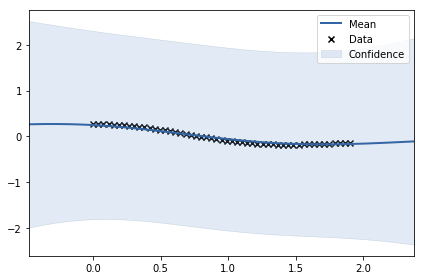

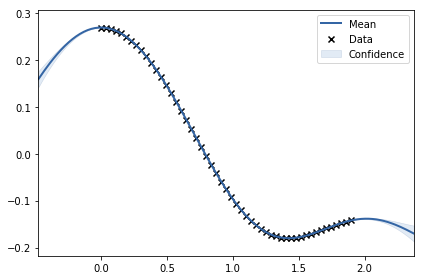

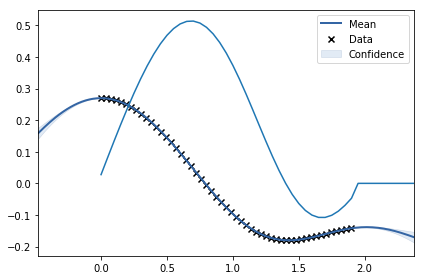

In [8]:
#
# Gaussian Process
# Thermodynamics Force Calculation by Gaussian Processing Method
# 
# Masa Watanabe
# Berkeley National Lab, Summer 2018
# University of Saint Mary
# Version 0.2
#
#

import numpy as np
from matplotlib import pyplot as plt
import GPy
from IPython.display import display
from scipy.interpolate import interp1d

#
# Molar Mass of molecules
# 
mass = 18.0  # Molar Mass of Water (as example)

#
# Expected mean or reference # denisty of the system
#
mean = 33.3  # Reference density of Water (as example)

#
# Density File Name
#
InFileName = 'Density.dat'  # (As example)

#
# initial hyperprameter for GP
#
d = 1      # input dimension
var = 1    # variance
theta = 1  # lengthscale


N = 0
f = open(InFileName, 'r')
for line in f:
    li=line.strip()
    if (not li.startswith("#")) and (not li.startswith("@")):
        N += 1
f.close()

X = np.zeros(shape=(N,1))
Y = np.zeros(shape=(N,1))

LineNumber = 0
InFile = open(InFileName, 'r')
for line in InFile:
    li=line.strip()
    if (not li.startswith("#")) and (not li.startswith("@")):
        row = line.split()
        #Index the counter used to keep track of line number
        X[LineNumber] = float(row[0])
        #
        # Substracting the mean from the observed data
        # This Gaussian Processing assumes that mean function is near zero.
        #
        Y[LineNumber] = float(row[1]) - mean
        LineNumber += 1
InFile.close()
# -----------------------------------

# define kernel
#ker = GPy.kern.Matern52(2,ARD=True) + GPy.kern.White(2)

kernel = GPy.kern.RBF(d, var, theta)

m = GPy.models.GPRegression(X,Y,kernel)

fig = m.plot()
GPy.plotting.show(fig, filename='basic_gp_regression_notebook')
display(m)

m.optimize(messages=True)
m.optimize_restarts(num_restarts = 10)

fig = m.plot()
GPy.plotting.show(fig, filename='basic_gp_regression_notebook_optimized')
display(m)

#fig = m.plot(plot_density=True)
#GPy.plotting.show(fig, filename='basic_gp_regression_density_notebook_optimized')
#display(m)

#m.predict(m.X)

Xp = np.arange(0,2.0,0.05).reshape(-1,1)
Yp = m.predict(Xp)[0]

Xp1 = np.arange(2.0,6.0,0.05).reshape(-1,1)
Yp1 = np.ones(shape=(len(Xp1),1)) * Yp[len(Xp)-1]

Xp2 = np.vstack((Xp,Xp1))
Yp2 = np.vstack((Yp,Yp1))

X = np.concatenate(Xp2)
Y = np.concatenate(Yp2)
#Xp1 = Xp[~np.isnan(Vp)]
#Vp1 = Vp[~np.isnan(Vp)]

#Dataout = np.column_stack((Xp,Yp))
#np.savetxt('RDF_dat',(Dataout),fmt=('%10.5f', '%12.6f'))

#
# Numerical derivative
#
dy = np.zeros(Y.shape,np.float)
#dy = np.zeros(shape=(len(Yp),1))
dy[0:-1] = np.diff(Y)/np.diff(X)
dy[-1] = (Y[-1] - Y[-2])/(X[-1] - X[-2])  # last derivative


fig = m.plot()
plt.plot(X, -dy)
plt.show()

#Xp1 = np.arange(2.0,6.0,0.05)
#Yp1 = np.ones(shape=(len(Xp1),1)) * Yp[len(Xp)-1]

#Da1 = np.column_stack((Xp1,mass*(Yp1+mean),-Yp1 * mass))
#Da2= np.column_stack((X,mass*(Y+mean), -dy * mass))
#Dataout = np.vstack((Da2,Da1))
Dataout = np.column_stack((Xp2,mass*(Yp2+mean),-dy * mass))
np.savetxt('dens_gp.xvg',(Dataout),fmt=('%10.5f', '%12.6f', '%12.6f'))

AA = mass*(Yp2+mean)

Dataout = np.column_stack((Xp2,(AA - AA[-1]),-dy * mass))
np.savetxt('dens_gp_s.xvg',(Dataout),fmt=('%10.5f', '%12.6f', '%12.6f'))